# Librerías

In [ ]:
#Librerías Base
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Librerías de Métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale

In [ ]:
#Librerías de Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop
from keras.models import Sequential
from keras.layers import LSTM

# Conexión al repositorio de datos

In [ ]:
#Accedemos a Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones utilitarias

In [ ]:
#Funcion utilitaria
def predecir_red_recurrente(cantidad_predicciones, data_sin_escalar, features):
  #Aqui colocaremos las predicciones
  predicciones = np.zeros(cantidad_predicciones)

  #Copiamos los datos a procesar
  input = features

  #Obtenemos el escalador
  sc = MinMaxScaler()
  x_scaler = sc.fit_transform(data_sin_escalar)

  #Iteramos la cantidad de predicciones solicitadas
  for i in range(0, cantidad_predicciones):
    #Convertimos en un array numpy
    features_numpy = np.array(input)

    #Tensorizamos
    input_tensor = features_numpy[None, None, :]

    #Predecimos
    prediccion = model.predict(input_tensor)

    #Des-escalamos
    prediccion_no_escalada = sc.inverse_transform(prediccion)[0][0]

    #Colocamos la prediccion en el array
    predicciones[i] = prediccion_no_escalada

    #Modificamos vector de features agregando la predicción y eliminando el último elemento
    input = [prediccion_no_escalada] + input[:-1]
  
  #Devolvemos las predicciones
  return predicciones

# Featuring

In [ ]:
#Cargaremos un dataset de ventas
#Este dataset contiene las ventas mensuales de una cadena de tiendas
df = pd.read_csv('/content/drive/MyDrive/Data/ventas.csv')
df

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


In [ ]:
#Vamos a cambiar los nombres de los campos por nombres más intuitivos
df1 = df.rename(columns = {
  'Adjustments': 'Mes', 
  'Unadjusted': 'Monto', 
  'Seasonally adjusted': 'Monto_Aprox'
})

df1

,Mes,Monto,Monto_Aprox
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


In [ ]:
#Vamos a seleccionar los campos que nos interesan
df2 = df1[['Mes', 'Monto']]
df2

,Mes,Monto
0,Jan-1991,12588862
1,Feb-1991,12154321
2,Mar-1991,14337072
3,Apr-1991,15108570
4,May-1991,17225734
...,...,...
308,Sep-2016,45528702
309,Oct-2016,44770113
310,Nov-2016,46285062
311,Dec-2016,50016137


In [ ]:
#Creamos un nuevo campo llamado "Fecha" formateando el campo "Mes"
df2['Fecha'] = pd.to_datetime(df2['Mes'], format='%b-%Y', errors = 'ignore')
df2

,Mes,Monto,Fecha
0,Jan-1991,12588862,1991-01-01
1,Feb-1991,12154321,1991-02-01
2,Mar-1991,14337072,1991-03-01
3,Apr-1991,15108570,1991-04-01
4,May-1991,17225734,1991-05-01
...,...,...,...
308,Sep-2016,45528702,2016-09-01
309,Oct-2016,44770113,2016-10-01
310,Nov-2016,46285062,2016-11-01
311,Dec-2016,50016137,2016-12-01


In [ ]:
#Eliminamos el campo "Mes"
del df2['Mes']

In [ ]:
#Si consultamos, solo tenemos dos campos, la fecha (que representa la estacionalidad) y el monto de ventas
#También notemos que como ahora el campo "Fecha" es un "date" le ha agregado el primer día del mes a cada mes
df2

,Monto,Fecha
0,12588862,1991-01-01
1,12154321,1991-02-01
2,14337072,1991-03-01
3,15108570,1991-04-01
4,17225734,1991-05-01
...,...,...
308,45528702,2016-09-01
309,44770113,2016-10-01
310,46285062,2016-11-01
311,50016137,2016-12-01


In [ ]:
#Agregamos el último día del mes a todas las fechas
df2['Fecha'] = df2['Fecha'] + MonthEnd(1)
df2

,Monto,Fecha
0,12588862,1991-01-31
1,12154321,1991-02-28
2,14337072,1991-03-31
3,15108570,1991-04-30
4,17225734,1991-05-31
...,...,...
308,45528702,2016-09-30
309,44770113,2016-10-31
310,46285062,2016-11-30
311,50016137,2016-12-31


In [ ]:
#Ahora ordenamos el dataframe en función del campo fecha, de menor a mayor
df3 = df2.sort_values('Fecha')
df3

,Monto,Fecha
0,12588862,1991-01-31
1,12154321,1991-02-28
2,14337072,1991-03-31
3,15108570,1991-04-30
4,17225734,1991-05-31
...,...,...
308,45528702,2016-09-30
309,44770113,2016-10-31
310,46285062,2016-11-30
311,50016137,2016-12-31


In [ ]:
#Reasignamos al campo fecha como índice del dataframe
df3 = df3.set_index('Fecha')
df3

,Monto
Fecha,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734
...,...
2016-09-30,45528702
2016-10-31,44770113
2016-11-30,46285062


# División en datos de entrenamiento y validación

In [ ]:
#Para realizar el corte, tenemos que tener los datos ordenados e indicar hasta que fecha se usará la data para entrenar
#Debemos definir la fecha como un tipo date
fecha_entrenar = pd.Timestamp('2011-01-01')
fecha_entrenar

Timestamp('2011-01-01 00:00:00')

In [ ]:
#Hacemos el corte para entrenar
dfTrain = df3.loc[:fecha_entrenar]
dfTrain

,Monto
Fecha,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734
...,...
2010-08-31,37395330
2010-09-30,36923390
2010-10-31,37014326


In [ ]:
#Hacemos el corte para validar
dfTest = df3.loc[fecha_entrenar:]
dfTest

,Monto
Fecha,
2011-01-31,31191594
2011-02-28,29797949
2011-03-31,36099866
2011-04-30,38035760
2011-05-31,40046516
...,...
2016-09-30,45528702
2016-10-31,44770113
2016-11-30,46285062


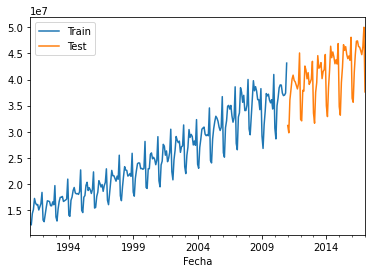

In [ ]:
#Graficamos los datos de entrenamiento y validación

#Graficamos la data de entrenamiento y obtenemos el cuadro en donde se dibujo
ejes = dfTrain.plot()

#Usamos estos ejes para dibujar la data de validación
dfTest.plot(ax = ejes)

#Agregamos una leyenda
plt.legend(['Train', 'Test'])

In [ ]:
#Finalmente, escalamos los datos
sc = MinMaxScaler()

In [ ]:
#Como aplicaremos Rolling Windows, solo necesitaremos los x_train y x_test
x_train = sc.fit_transform(dfTrain)
x_test = sc.transform(dfTest)

# Definición de features y labels

In [ ]:
#Para aplicar esta técnica, deberemos volver a convertir los tensores en dataframes pandas
dfTrain = pd.DataFrame(x_train.reshape(-1), columns=['Monto'])
dfTest = pd.DataFrame(x_test.reshape(-1), columns=['Monto'])

In [ ]:
#Le agreamos los features necesarios
for salto in range(1, 12):
  dfTrain['anterior_{}'.format(salto)] = dfTrain['Monto'].shift(salto)
  dfTest['anterior_{}'.format(salto)] = dfTest['Monto'].shift(salto)

In [ ]:
#Eliminamos los nulos
dfTrain = dfTrain.dropna()
dfTest = dfTest.dropna()

In [ ]:
#Obtenemos los valores en un array tensorial
#Para los features usaremos todos los valores previos al mes
x_train_tensor = dfTrain.loc[:, dfTrain.columns != 'Monto'].values
x_train_tensor.shape

(229, 11)

In [ ]:
#En este caso los "y" son la columna "Monto"
y_train_tensor = dfTrain['Monto'].values
y_train_tensor.shape

(229,)

In [ ]:
#Finalmente obtenemos los valores en un array tensorial
x_test_tensor = dfTest.loc[:, dfTest.columns != 'Monto'].values
x_test_tensor.shape

(62, 11)

In [ ]:
#En este caso los "y" son la columna "Monto"
y_test_tensor = dfTest['Monto'].values
y_test_tensor.shape

(62,)

# Tensor de orden 3 estándar para las redes recurrentes

In [ ]:
#Estas son las variables que procesaremos
x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape

((229, 11), (229,), (62, 11), (62,))

In [ ]:
#A los features deberemos darle la forma tensorial de orden 3 que necesitan las redes recurrentes
#Primero lo haremos con los features de entrenamiento
x_train_tensor_rr = x_train_tensor[:, None, :]
x_train_tensor_rr.shape

(229, 1, 11)

In [ ]:
#Ahora los features de validación
x_test_tensor_rr = x_test_tensor[:, None, :]
x_test_tensor_rr.shape

(62, 1, 11)

# Implementación de Red Recurrente

In [ ]:
#Instanciamos un modelo
model = Sequential()

In [ ]:
#Agregamos una capa de recurrente de 6 neuronas, en input_shape deberemos colocar de cuánto en cuánto se procesan los datos (1) y luego cuántos features tenemos (11)
#Con "return_sequences" devolvemos lo procesado para la siguiente capa
model.add(LSTM(6, input_shape=(1, 11), return_sequences=True))

In [ ]:
#Agregamos otra capa
model.add(LSTM(7, return_sequences=True))

In [ ]:
#Agregamos la última capa, como es la última LSTM no necesita el "return_sequences"
model.add(LSTM(5))

In [ ]:
#Agregamos la neurona de salida
model.add(Dense(1))

# Compilación

In [ ]:
#Compilamos
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenamiento

In [ ]:
#Entrenamos
model.fit(
  x_train_tensor_rr, 
  y_train_tensor, 
  epochs=100,
  batch_size=2, 
  verbose=1
)

Epoch 1/100
115/115 [==============================] - 6s 4ms/step - loss: 0.1500
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0261
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0149
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0106
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0091
Epoch 6/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 7/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 8/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 9/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 10/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 11/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0091
Epoch 12/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 13/100


# Uso del modelo

In [ ]:
#Cargaremos un dataset original para re-escalar las predicciones
dfData = pd.read_csv('/content/drive/MyDrive/Data/ventas.csv')
dfData

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


In [ ]:
#Usamos la función para obtener las predicciones de los próximos 5 meses
predicciones = predecir_red_recurrente(5, dfData[['Unadjusted']], [1.101218, 1.052339, 1.076814, 1.098520, 1.102388, 1.137163, 1.135161, 1.055935, 0.943724, 0.758063, 0.782767])
predicciones

array([47766856., 47067480., 47067480., 47067480., 41613508.])